<h1 style="font-size:30px; font-weight:700;">Ames Housing — Linear Regression</h1>
<p style="font-size:16px;"><strong>Goal:</strong> Build a Linear Regression baseline to predict <code>SalePrice</code> using the Ames Housing benchmark dataset.

Notebook structure: load data → EDA → preprocess → train → evaluate → visualize → save.</p>



<h2 style="font-size:20px; font-weight:700;">Prerequisites</h2>
<p>Install required Python packages.</p>


In [1]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn joblib


<h2 style="font-size:22px; font-weight:700;">1) Imports & Constants</h2>
<p>Import necessary libraries for preprocessing, modeling, evaluation, and visualization.</p>



In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression

sns.set(style="whitegrid")
RANDOM_STATE = 42

print("Libraries loaded successfully.")


Libraries loaded successfully.


<h2 style="font-size:22px; font-weight:700;">2) Load Dataset (From Colab Files)</h2>
<p>Since the dataset is already uploaded, we load it directly from the Colab file system. Replace the filename if different.</p>


In [3]:
# Replace filename if your uploaded dataset has a different name
file_path = "/content/AmesHousing.csv"

df = pd.read_csv(file_path)
print("Dataset loaded from:", file_path)
print("Shape:", df.shape)
df.head()


Dataset loaded from: /content/AmesHousing.csv
Shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


<h2 style="font-size:22px; font-weight:700;">3) Quick Exploratory Data Analysis</h2>
<p>View target distribution and missing values to understand data quality before preprocessing.</p>


<h2 style="font-size:22px; font-weight:700;">3.1) Dataset Structure & Data Types</h2>
<p>Check the structure, data types, and number of non-null entries for each column. This helps understand feature distribution and required cleaning.</p>


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

<h2 style="font-size:22px; font-weight:700;">3.2) Numerical Summary Statistics</h2>
<p>View basic statistics (mean, median, percentiles) for all numerical columns.</p>



In [9]:
df.describe()


,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


<h2 style="font-size:22px; font-weight:700;">Define Numeric & Categorical Features</h2>
<p>These feature lists must be defined before using them in EDA or preprocessing.</p>



In [12]:
numeric_features = [
    "Lot Area", "Overall Qual", "Overall Cond", "Year Built", "Year Remod/Add",
    "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF",
    "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Gr Liv Area",
    "Full Bath", "Half Bath", "Bedroom AbvGr", "Kitchen AbvGr",
    "TotRms AbvGrd", "Fireplaces", "Garage Cars", "Garage Area",
    "Wood Deck SF", "Open Porch SF"
]

categorical_features = [
    "MS Zoning", "Street", "Lot Shape", "Land Contour", "Neighborhood",
    "House Style", "Roof Style", "Exterior 1st", "Exterior 2nd", "Central Air",
    "Kitchen Qual", "Functional", "Paved Drive", "Sale Type", "Sale Condition"
]

# Filter only features that exist in your dataset
numeric_features = [col for col in numeric_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF']
Categorical features: ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Neighborhood', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Central Air', 'Kitchen Qual', 'Functional', 'Paved Drive', 'Sale Type', 'Sale Condition']


<h2 style="font-size:22px; font-weight:700;">3.3) Categorical Feature Summary</h2>
<p>Check how many unique values each categorical column has. This is important for encoding.</p>


In [13]:
df[categorical_features].nunique()


,0
MS Zoning,7
Street,2
Lot Shape,4
Land Contour,4
Neighborhood,28
House Style,8
Roof Style,6
Exterior 1st,16
Exterior 2nd,17
Central Air,2


In [14]:
df[numeric_features].describe()


,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF
count,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,2929.000000,2929.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2929.000000,2929.000000,2930.000000,2930.000000
mean,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,442.629566,49.722431,559.262547,1051.614544,...,1.566553,0.379522,2.854266,1.044369,6.443003,0.599317,1.766815,472.819734,93.751877,47.533447
std,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,455.590839,169.168476,439.494153,440.615067,...,0.552941,0.502629,0.827731,0.214076,1.572964,0.647921,0.760566,215.046549,126.361562,67.483400
min,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,219.000000,793.000000,...,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,320.000000,0.000000,0.000000
50%,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,466.000000,990.000000,...,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,27.000000
75%,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,734.000000,0.000000,802.000000,1302.000000,...,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,70.000000
max,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,...,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,5.000000,1488.000000,1424.000000,742.000000


<h2 style="font-size:22px; font-weight:700;">3.4) Missing Value Heatmap</h2>
<p>Visualize missing values to see patterns in the dataset.</p>


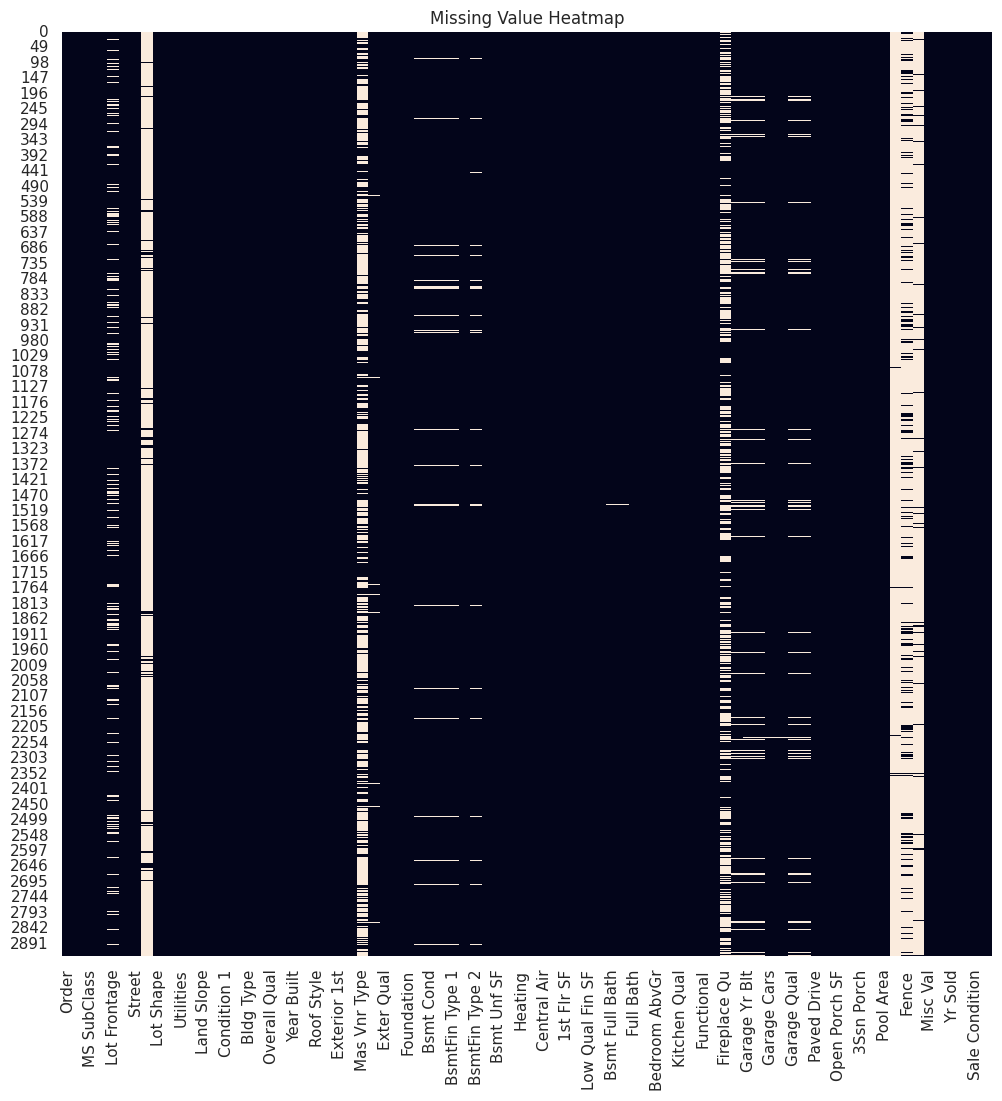

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()


<h2 style="font-size:22px; font-weight:700;">EDA Plot 1 — Distribution of Numerical Features</h2>
<p>Plot histograms for all numerical features to check skewness and distribution patterns.</p>


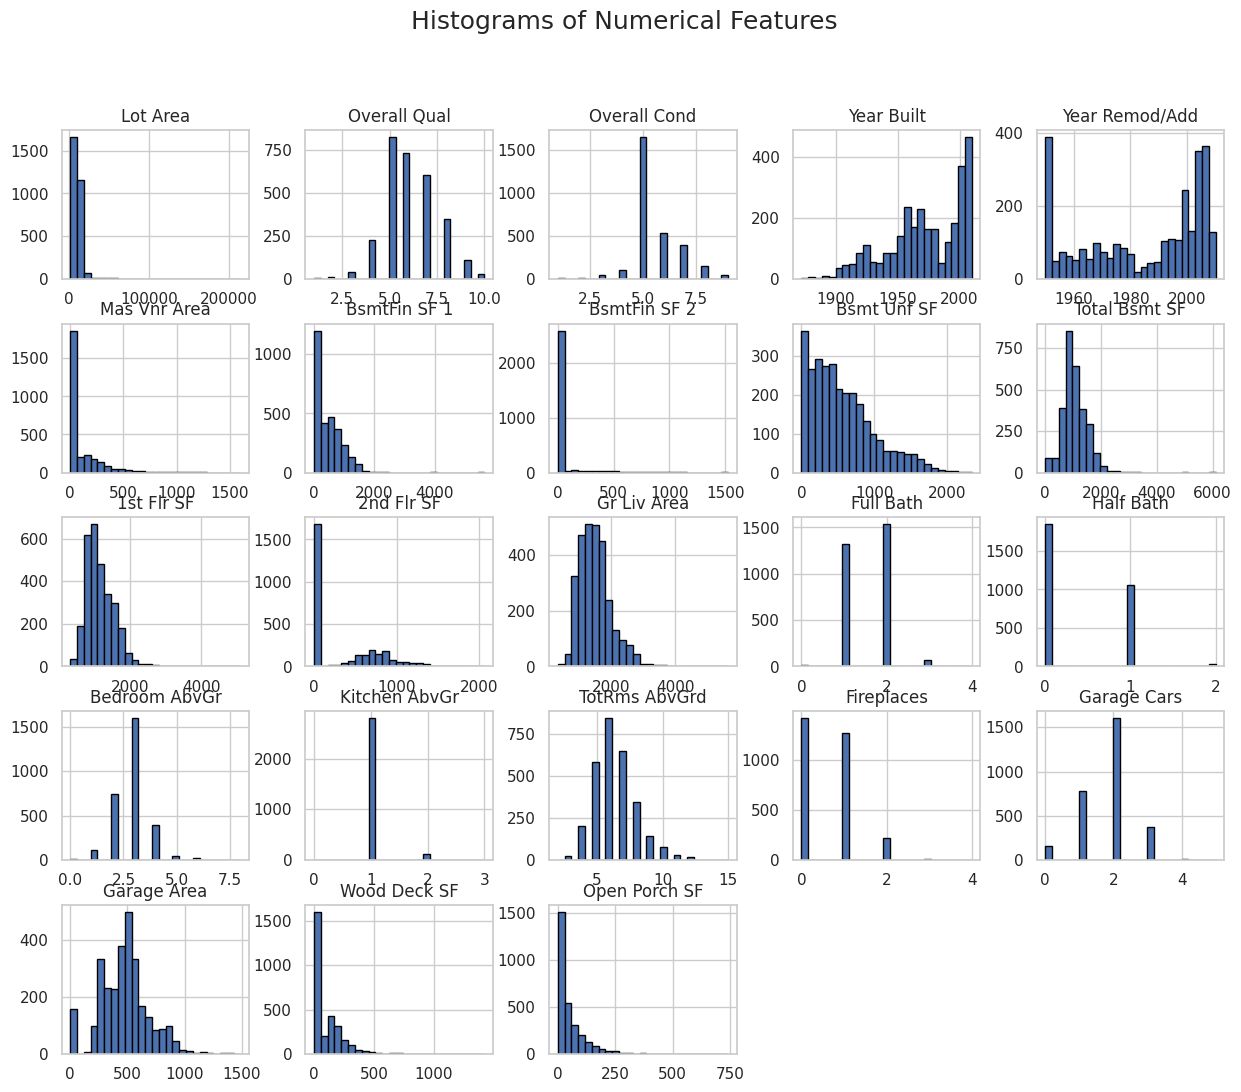

In [16]:
df[numeric_features].hist(figsize=(15,12), bins=25, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=18)
plt.show()


<h2 style="font-size:22px; font-weight:700;">EDA Plot 2 — Outlier Detection (Boxplots)</h2>
<p>Boxplots help identify extreme values that can hurt model performance.</p>


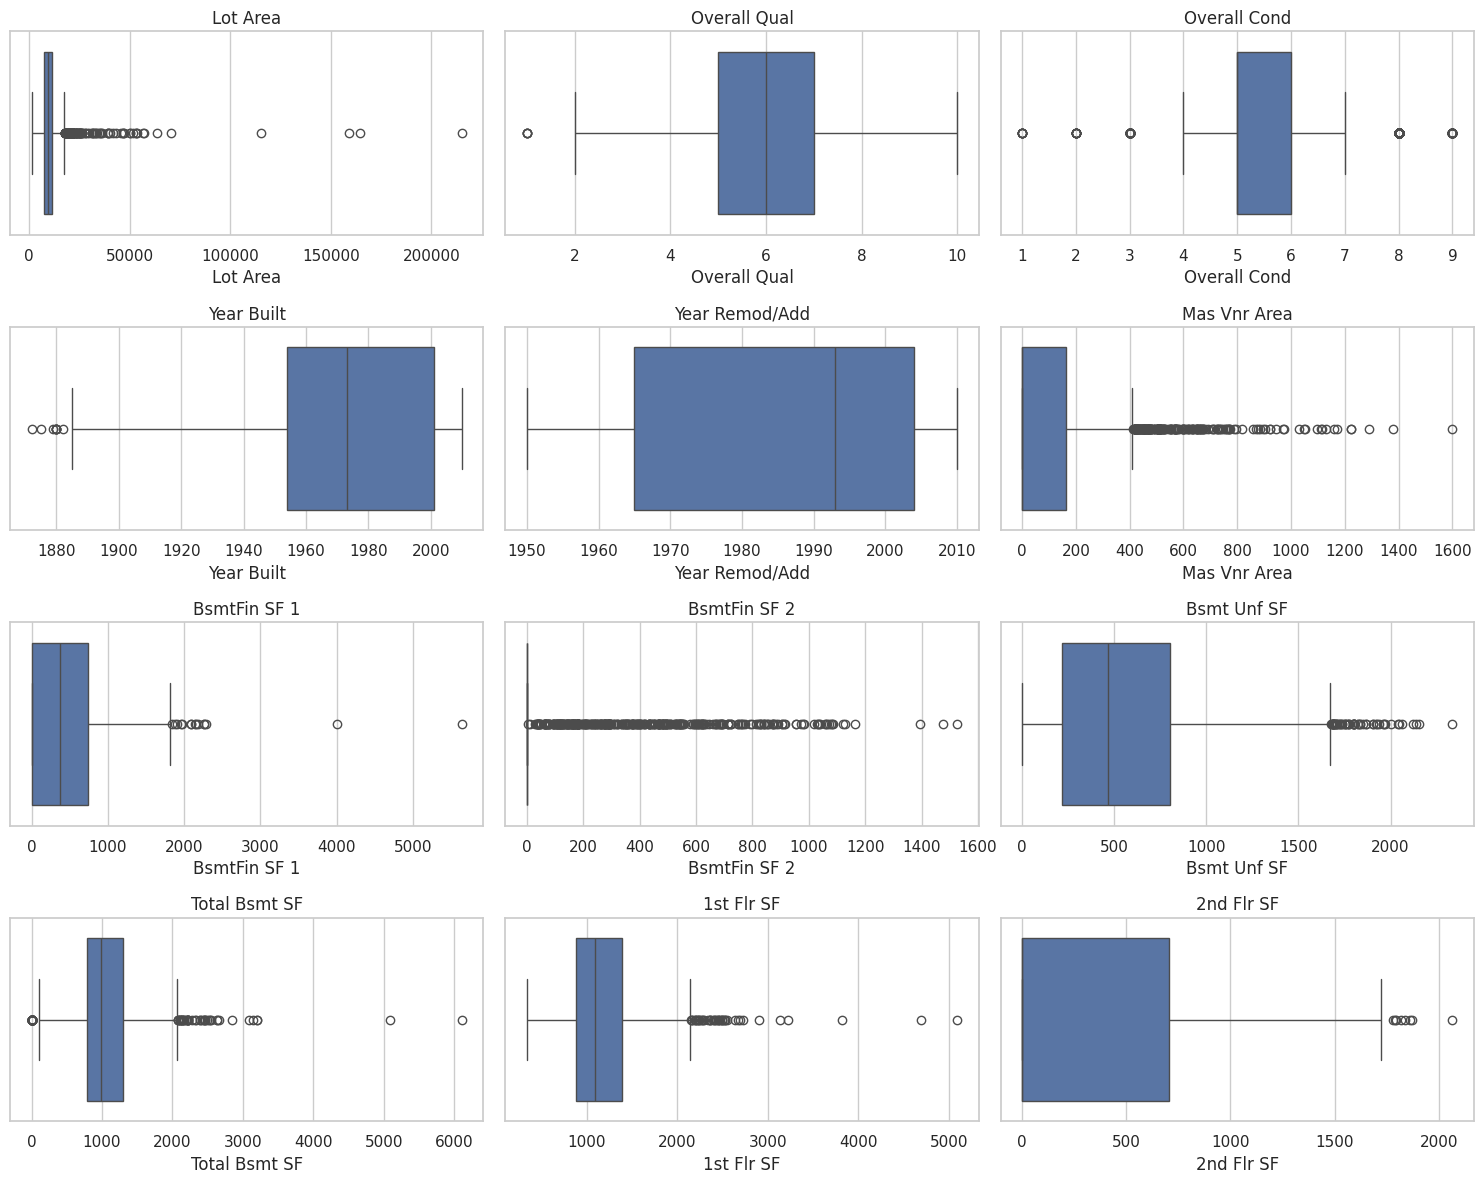

In [17]:
plt.figure(figsize=(15,12))
for i, col in enumerate(numeric_features[:12]):  # limit for readability
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


<h2 style="font-size:22px; font-weight:700;">EDA Plot 3 — Scatterplots of Key Features vs SalePrice</h2>
<p>Visualize linear relationships between important predictors and target.</p>


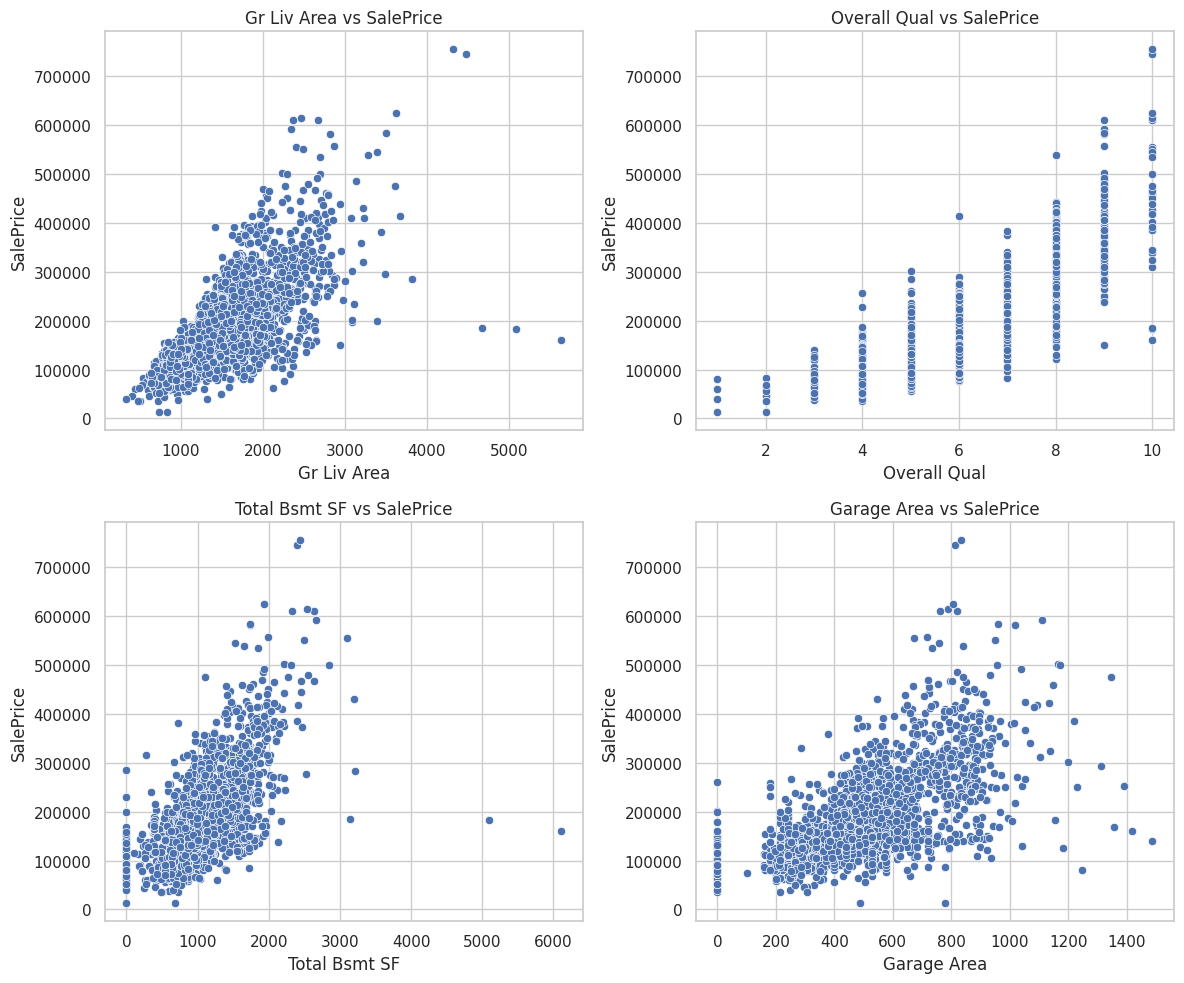

In [18]:
top_features = ["Gr Liv Area", "Overall Qual", "Total Bsmt SF", "Garage Area"]

plt.figure(figsize=(12,10))
for i, col in enumerate(top_features):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=df[col], y=df["SalePrice"])
    plt.title(f"{col} vs SalePrice")
plt.tight_layout()
plt.show()


<h2 style="font-size:22px; font-weight:700;">EDA Plot 4 — Mean SalePrice by Categorical Feature</h2>
<p>Shows how house prices vary across different groups (e.g., Neighborhood, House Style).</p>


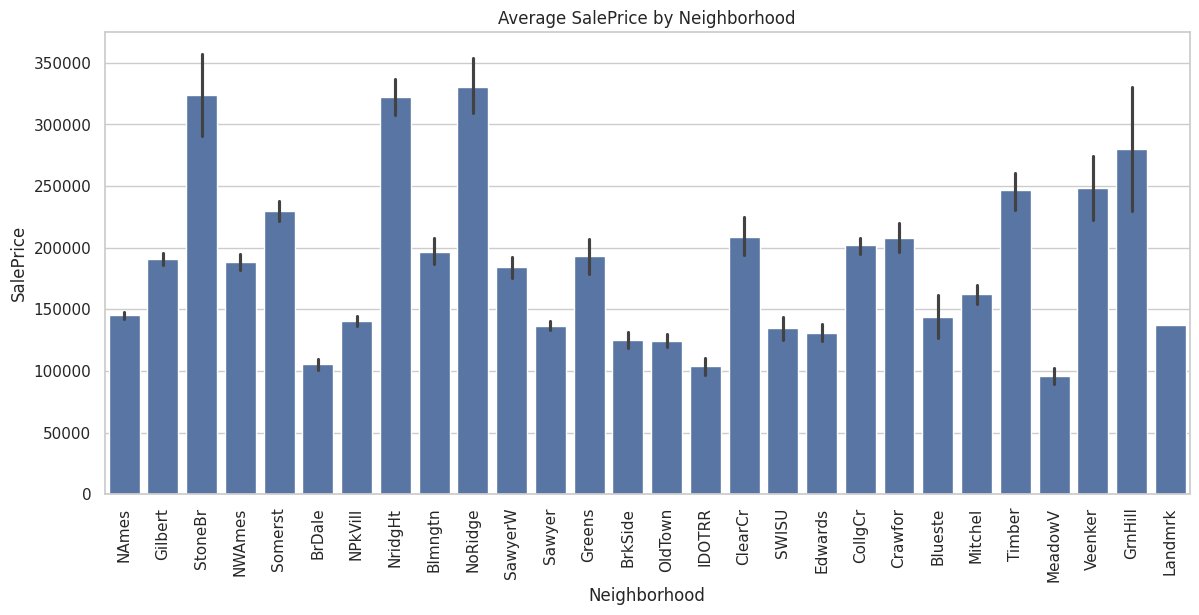

In [19]:
plt.figure(figsize=(14,6))
sns.barplot(x=df["Neighborhood"], y=df["SalePrice"])
plt.title("Average SalePrice by Neighborhood")
plt.xticks(rotation=90)
plt.show()


<h2 style="font-size:22px; font-weight:700;">EDA Plot 5 — Correlation Heatmap</h2>
<p>Displays correlation between numerical variables and highlights multicollinearity.</p>


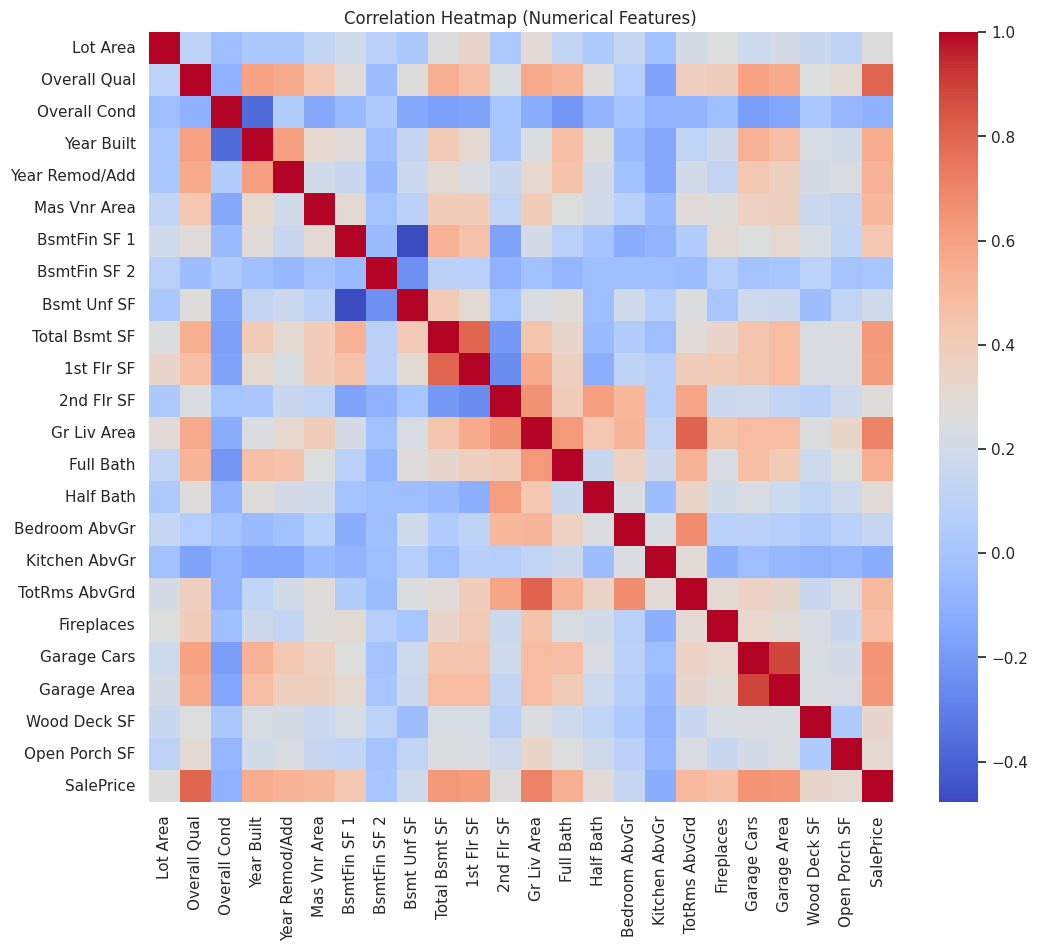

In [20]:
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_features + ["SalePrice"]].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


<h2 style="font-size:22px; font-weight:700;">EDA Plot 6 — Top Correlations with SalePrice</h2>
<p>Rank features by correlation strength with SalePrice.</p>


In [21]:
corr_values = df[numeric_features + ["SalePrice"]].corr()["SalePrice"].sort_values(ascending=False)
corr_values


,SalePrice
SalePrice,1.000000
Overall Qual,0.799262
Gr Liv Area,0.706780
Garage Cars,0.647877
Garage Area,0.640401
Total Bsmt SF,0.632280
1st Flr SF,0.621676
Year Built,0.558426
Full Bath,0.545604
Year Remod/Add,0.532974


<h2 style="font-size:22px; font-weight:700;">Preprocessing — Overview</h2>
<p>This section prepares the data for modeling. Steps included:</p>
<ul>
  <li>Make a working copy (<code>df_clean</code>)</li>
  <li>Define numeric and categorical feature lists (safe defaults)</li>
  <li>Logical fills for "no feature" cases (garage/basement)</li>
  <li>Missing-value summary and strategy</li>
  <li>Group rare categories</li>
  <li>Simple ordinal mappings (quality/condition)</li>
  <li>Skew detection & transform</li>
  <li>Final preprocessing pipeline (impute/scale/encode)</li>
</ul>



In [23]:
# Create working copy
df_clean = df.copy()

print(f"Numeric features ({len(numeric_features)}): {numeric_features[:10]}{'...' if len(numeric_features)>10 else ''}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features[:10]}{'...' if len(categorical_features)>10 else ''}")


Numeric features (23): ['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']...
Categorical features (15): ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Neighborhood', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Central Air']...


<h3 style="font-size:18px; font-weight:600;">Logical fills</h3>
<p>Fill missing values that logically mean "none" (e.g., no garage, no basement) with zeros or 'None'. This prevents incorrect median/mode imputation later.</p>


In [24]:
# Columns where NaN practically means zero
logical_zero_cols = [
    "BsmtFin SF 1","BsmtFin SF 2","Bsmt Unf SF","Total Bsmt SF",
    "Garage Cars","Garage Area","Pool Area","Mas Vnr Area"
]
for col in logical_zero_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(0)

# Categorical columns where NaN means "None" (no feature)
cat_fill_none = ["Garage Type","Garage Finish","Fence","Mas Vnr Type","Alley","Fireplace Qu"]
for col in cat_fill_none:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna("None")

print("Logical fills applied.")


Logical fills applied.


<h3 style="font-size:18px; font-weight:600;">Missing-value summary & plan</h3>
<p>Show remaining missingness, percent missing, and create a plan: (a) drop cols with >30% missing, (b) for numeric median impute, (c) categorical use 'MISSING' for rare/unseen.</p>


In [25]:
missing_count = df_clean.isnull().sum()
missing_percent = (missing_count / len(df_clean)) * 100
missing_summary = pd.DataFrame({"count": missing_count, "percent": missing_percent})
missing_summary = missing_summary[missing_summary["count"] > 0].sort_values("percent", ascending=False)
display(missing_summary.head(40))

# Columns with >30% missing
cols_drop = missing_summary[missing_summary["percent"] > 30].index.tolist()
print("Columns with >30% missing (consider dropping):", cols_drop)


,count,percent
Pool QC,2917,99.556314
Misc Feature,2824,96.382253
Lot Frontage,490,16.723549
Garage Yr Blt,159,5.426621
Garage Cond,159,5.426621
Garage Qual,159,5.426621
Bsmt Exposure,83,2.832765
BsmtFin Type 2,81,2.764505
Bsmt Qual,80,2.730375
Bsmt Cond,80,2.730375


Columns with >30% missing (consider dropping): ['Pool QC', 'Misc Feature']


<h3 style="font-size:18px; font-weight:600;">Group rare categories</h3>
<p>Map categories that occur in &lt;1% of rows to a single 'RARE' label to reduce one-hot sparsity.</p>


In [26]:
for col in categorical_features:
    if col in df_clean.columns:
        freqs = df_clean[col].value_counts(normalize=True)
        rare = freqs[freqs < 0.01].index
        if len(rare) > 0:
            df_clean[col] = df_clean[col].replace(rare, "RARE")

print("Rare categories grouped (threshold: 1%).")


Rare categories grouped (threshold: 1%).


<h3 style="font-size:18px; font-weight:600;">Ordinal mapping</h3>
<p>Convert common ordinal text fields (like <code>Exter Qual</code>, <code>Kitchen Qual</code>) to numeric scales to preserve order.</p>


In [27]:
# Define common ordinal mappings (adjust if column names differ)
quality_map = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "None":0}
qual_cols = ["Exter Qual","Exter Cond","Kitchen Qual","Heating QC","Bsmt Qual","Bsmt Cond","Fireplace Qu"]
for col in qual_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].map(quality_map).fillna(0).astype(int)

print("Ordinal mappings applied where applicable.")


Ordinal mappings applied where applicable.


<h3 style="font-size:18px; font-weight:600;">Feature engineering (safe)</h3>
<p>Create a few robust features: total bathrooms, total finished basement area, house age, remodeled flag, and price-per-square-foot placeholder.</p>


In [28]:
# Total bathrooms (full + 0.5 * half) — guard for missing columns
if {"Full Bath","Half Bath"}.issubset(df_clean.columns):
    df_clean["TotalBathrooms"] = df_clean["Full Bath"].fillna(0) + 0.5 * df_clean["Half Bath"].fillna(0)

# Total finished basement
if {"BsmtFin SF 1","BsmtFin SF 2"}.issubset(df_clean.columns):
    df_clean["TotalBsmtFinished"] = df_clean["BsmtFin SF 1"].fillna(0) + df_clean["BsmtFin SF 2"].fillna(0)

# House age (at sale)
if {"Yr Sold","Year Built"}.issubset(df_clean.columns):
    df_clean["HouseAge"] = df_clean["Yr Sold"] - df_clean["Year Built"]

# Remodeled flag
if {"Year Remod/Add","Year Built"}.issubset(df_clean.columns):
    df_clean["Remodeled"] = (df_clean["Year Remod/Add"] != df_clean["Year Built"]).astype(int)

# Price per living area placeholder (requires SalePrice & Gr Liv Area)
if {"SalePrice","Gr Liv Area"}.issubset(df_clean.columns):
    df_clean["PricePerSqft"] = df_clean["SalePrice"] / df_clean["Gr Liv Area"].replace(0, np.nan)

print("Feature engineering complete (added safe features where columns exist).")


Feature engineering complete (added safe features where columns exist).


<h3 style="font-size:18px; font-weight:600;">Skew detection & transform</h3>
<p>Detect highly-skewed numeric features (skew &gt; 1) and apply <code>log1p</code>. We'll exclude binary / small-range ints where transform is not desirable.</p>


In [29]:
from scipy.stats import skew

# Rebuild numeric_features list to include new engineered numeric features
numeric_features = [c for c in numeric_features if c in df_clean.columns]
for new_col in ["TotalBathrooms","TotalBsmtFinished","HouseAge","QualityIndex","PricePerSqft"]:
    if new_col in df_clean.columns and new_col not in numeric_features:
        numeric_features.append(new_col)

# Find skewed numeric cols (exclude booleans and small-integer categorical-looking ones)
skewed = []
for col in numeric_features:
    # skip if too few unique values
    if df_clean[col].dropna().nunique() < 6:
        continue
    sval = skew(df_clean[col].dropna())
    if sval > 1:
        skewed.append(col)

print("Skewed numeric columns (skew > 1):", skewed)

# Apply log1p safely (clip negatives)
for col in skewed:
    # shift if negative values exist
    minval = df_clean[col].min()
    if pd.isna(minval):
        continue
    if minval <= -1:
        shift = abs(minval) + 1
        df_clean[col] = np.log1p(df_clean[col] + shift)
    else:
        df_clean[col] = np.log1p(df_clean[col].clip(lower=0))

print("Applied log1p transform to skewed numeric columns.")


Skewed numeric columns (skew > 1): ['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Wood Deck SF', 'Open Porch SF', 'TotalBsmtFinished']
Applied log1p transform to skewed numeric columns.


<h3 style="font-size:18px; font-weight:600;">Final preprocessing pipeline</h3>
<p>Define the sklearn pipeline: numeric = median impute + scale; categorical = constant impute + one-hot encode. The pipeline will be used inside a full model pipeline next.</p>


In [31]:
# Recompute categorical_features
categorical_features = [c for c in categorical_features if c in df_clean.columns]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")

print("Preprocessor ready.")
print(f"Numeric features: {len(numeric_features)}, Categorical features (to be one-hot): {len(categorical_features)}")


Preprocessor ready.
Numeric features: 27, Categorical features (to be one-hot): 15


<h2 style="font-size:20px; font-weight:700;">Train / Test Split</h2>
<p>Split cleaned data into training and testing sets. We train on a log-transformed target for stability.</p>


In [32]:
# sanity check
if "df_clean" not in globals():
    raise RuntimeError("df_clean not found. Run preprocessing cells first.")

if "SalePrice" not in df_clean.columns:
    raise RuntimeError("SalePrice column not found in df_clean.")

# create log target (if not already present)
if "SalePrice_log" not in df_clean.columns:
    df_clean["SalePrice_log"] = np.log1p(df_clean["SalePrice"])

# Define X and y using current numeric_features & categorical_features
X = df_clean[numeric_features + categorical_features].copy()
y_log = df_clean["SalePrice_log"].copy()

# train/test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.20, random_state=RANDOM_STATE
)

print("Shapes — X_train:", X_train.shape, "X_test:", X_test.shape)


Shapes — X_train: (2344, 42) X_test: (586, 42)


<h2 style="font-size:20px; font-weight:700;">Build Model Pipeline</h2>
<p>Pipeline = preprocessor → SelectKBest (optional) → LinearRegression. SelectKBest is capped safely so k does not exceed the feature space.</p>


In [33]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

# Choose K_BEST; reduce if your encoded feature space is small
K_BEST = 200

# Create pipeline with a safe K selection: we'll compute feature count after fitting preprocessor in a helper step if needed.
model_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", SelectKBest(score_func=f_regression, k=min(K_BEST, 10000))),  # min cap; replaced later if needed
    ("model", LinearRegression())
])

print("Model pipeline created (preprocessor + SelectKBest + LinearRegression).")


Model pipeline created (preprocessor + SelectKBest + LinearRegression).


<h2 style="font-size:20px; font-weight:700;">Fit Model Pipeline</h2>
<p>Fit the full pipeline on the training set. This will run the preprocessor, selection, and regression.</p>


In [34]:
# Fit — may take some time depending on one-hot cardinality
model_pipeline.fit(X_train, y_train_log)
print("Pipeline training complete.")


Pipeline training complete.


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=200 is greater than n_features=117. All the features will be returned.
  warnings.warn(


<h2 style="font-size:20px; font-weight:700;">Evaluate</h2>
<p>Predict on test set, convert back to original SalePrice scale, and compute R² and RMSE.</p>


In [35]:
# Predictions (log space)
y_pred_log = model_pipeline.predict(X_test)

# Convert back to original price scale
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_log = r2_score(y_test_log, y_pred_log)

print(f"R² (original price scale): {r2:.4f}")
print(f"RMSE (original price scale): {rmse:,.2f}")
print(f"R² (log-target): {r2_log:.4f}")


R² (original price scale): 0.9795
RMSE (original price scale): 12,826.29
R² (log-target): 0.9880


<h2 style="font-size:20px; font-weight:700;">Diagnostics & Plots</h2>
<p>Actual vs Predicted, Residuals vs Predicted, and Residual distribution.</p>


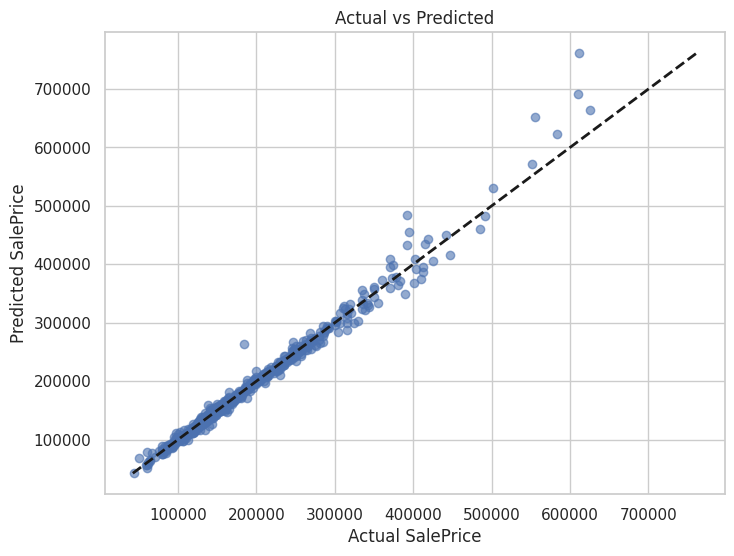

In [38]:
# Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
minv, maxv = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([minv, maxv], [minv, maxv], 'k--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()





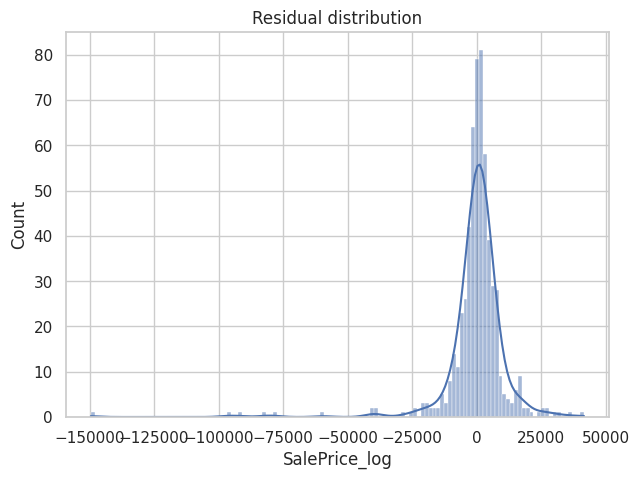

In [37]:
# Residual distribution
plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.title("Residual distribution")
plt.show()


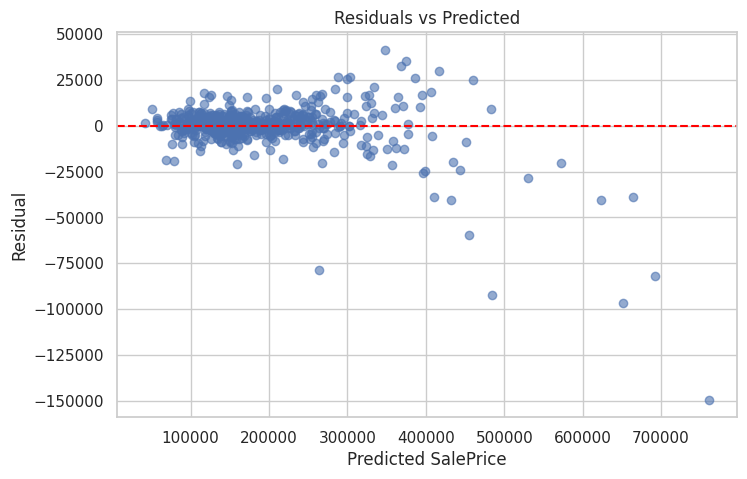

In [39]:
# Residuals vs Predicted
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()

<h2 style="font-size:20px; font-weight:700;">Feature Names & Coefficients</h2>
<p>Reconstruct feature names after preprocessing, map SelectKBest support back, and show top coefficients by absolute value. Works across scikit-learn versions.</p>


In [40]:
# Helper: get feature names from preprocessor (robust)
pre = model_pipeline.named_steps['preprocess']

try:
    # Modern sklearn: ColumnTransformer has get_feature_names_out
    feature_names = pre.get_feature_names_out()
    # If it returns with transformer__name prefixes, try to clean them
    feature_names = [fn if not fn.startswith("num__") and not fn.startswith("cat__") else fn.split("__",1)[1] for fn in feature_names]
except Exception:
    # Fallback manual reconstruction
    num_names = numeric_features
    cat_ohe_names = []
    if len(categorical_features) > 0:
        try:
            cat_tr = pre.named_transformers_['cat']
            ohe = cat_tr.named_steps['onehot']
            cat_ohe_names = list(ohe.get_feature_names_out(categorical_features))
        except Exception:
            # older fallback
            try:
                cat_ohe_names = ohe.get_feature_names(categorical_features).tolist()
            except Exception:
                cat_ohe_names = []
    feature_names = num_names + cat_ohe_names

# Now map through SelectKBest mask (if present)
if 'select' in model_pipeline.named_steps:
    selector = model_pipeline.named_steps['select']
    try:
        support = selector.get_support()
        selected_feature_names = [f for f, s in zip(feature_names, support) if s]
    except Exception:
        # If selector hasn't been fitted to reveal support, try computing using transformed shape
        selected_feature_names = feature_names
else:
    selected_feature_names = feature_names

# Get coefficients (handle multi-output possibility)
coefs = model_pipeline.named_steps['model'].coef_
if coefs.ndim > 1:
    coefs = coefs.ravel()

coef_df = pd.DataFrame({
    "feature": selected_feature_names,
    "coef": coefs
}).assign(abs_coef=lambda d: d['coef'].abs()).sort_values('abs_coef', ascending=False)

display(coef_df.head(30))


,feature,coef,abs_coef
12,Gr Liv Area,0.294082,0.294082
26,PricePerSqft,0.259975,0.259975
25,HouseAge,-0.135271,0.135271
3,Year Built,-0.121892,0.121892
72,Exterior 1st_AsbShng,-0.081094,0.081094
103,Functional_RARE,-0.072672,0.072672
80,Exterior 1st_VinylSd,0.049699,0.049699
91,Exterior 2nd_VinylSd,-0.045223,0.045223
35,Lot Shape_RARE,-0.033268,0.033268
61,Neighborhood_StoneBr,-0.032734,0.032734


<h2 style="font-size:20px; font-weight:700;">Save Model & Results</h2>
<p>Persist the trained pipeline and export test predictions to CSV.</p>


In [41]:
# Save trained pipeline
joblib.dump(model_pipeline, "ames_model_pipeline.joblib")
print("Saved pipeline to ames_model_pipeline.joblib")

# Save results dataframe
results = X_test.reset_index(drop=True).copy()
results['ActualSalePrice'] = y_test.values
results['PredictedSalePrice'] = y_pred
results['Residual'] = results['ActualSalePrice'] - results['PredictedSalePrice']
results.to_csv("ames_test_results.csv", index=False)
print("Saved test results to ames_test_results.csv")


Saved pipeline to ames_model_pipeline.joblib
Saved test results to ames_test_results.csv
